In [1]:
from MS2LDA.motif_parser import load_m2m_folder
from MS2LDA.Add_On.MassQL.MassQL4MotifDB import load_motifDB, motifDB2motifs
from MS2LDA.utils import retrieve_spec4doc

from MS2LDA.Add_On.Fingerprints.FP_annotation import annotate_motifs as calc_fingerprints

import pickle
import tomotopy as tp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

from rdkit.Chem import RDKFingerprint
from rdkit.DataStructs import TanimotoSimilarity
import numpy as np
from tqdm import tqdm
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import MolFromSmarts


from typing import Dict, List, Optional
from rdkit.Chem import MolFromSmiles, rdFMCS, RDKFingerprint
from rdkit.DataStructs import TanimotoSimilarity
import numpy as np
from tqdm import tqdm

from collections import defaultdict


In [2]:
motifDB_1, motifDB_2 = load_motifDB("/home/ioannis/thesis_data/filtered_pos_output_w1_1/motifset_optimized.json")
motifs = motifDB2motifs(motifDB_2)
with open('/home/ioannis/thesis_data/filtered_pos_output_w1_1/doc2spec_map.pkl', 'rb') as f:
    doc2spec_map = pickle.load(f)
lda_model = tp.LDAModel.load('/home/ioannis/thesis_data/filtered_pos_output_w1_1/ms2lda.bin')

In [3]:

#USEFUL

def safe_mol(smiles: Optional[str]):
    if smiles is None:
        return None
    try:
        return MolFromSmiles(smiles)
    except:
        return None

def calculate_sos(fp1, fp2):
    if sum(fp1) < sum(fp2):
        smaller_fp = fp1
        bigger_fp = fp2
    else:
        smaller_fp = fp2
        bigger_fp = fp1
    
    smaller_fp_sum = sum(smaller_fp)
    fp_intersection = 0
    for bit1, bit2 in zip(smaller_fp, bigger_fp):
        if bit1 == 1 and bit2 == 1:
            fp_intersection += 1

    if fp_intersection == 0:
        return 0
    else:
        return fp_intersection / smaller_fp_sum

def compute_pairwise_similarity(mols: List, threshold: float = 0.5) -> float:
    if len(mols) < 2:
        return 0.0
    fps = [RDKFingerprint(m) for m in mols]
    total = 0
    matches = 0
    n = len(fps)
    for i in range(n):
        for j in range(i + 1, n):
            total += 1
            if TanimotoSimilarity(fps[i], fps[j]) >= threshold:
                matches += 1
    return matches / total if total > 0 else 0.0


def compute_mcs_num_atoms(mols):
    if not mols:
        return 0, ""
    try:
        mcs = rdFMCS.FindMCS(
            mols,
            bondCompare=rdFMCS.BondCompare.CompareAny,
            completeRingsOnly=True,
            ringMatchesRingOnly=True,
            timeout=30,
        )
        return int(mcs.numAtoms), mcs.smartsString
    except:
        return 0, ""

In [ ]:
# def process_motifs(motifs, lda_model, doc2spec_map, prob_threshold: float = 0.5, sim_threshold: float = 0.5, sos_cal = True) -> dict:
#     motif_ids = []
#     num_atoms = []
#     len_frag_loss = []
#     mcs_smarts = []
#     intra_sims = []
#     inter_sims = []
#     molecules_by_motif = {}

#     for motif in tqdm(motifs):
#         annotation = motif.get("auto_annotation", [])
#         if len(annotation) <= 1:
#             continue

#         try:
#             motif_id = int(motif.get("id").split("_")[1])
#         except:
#             continue

#         motif_ids.append(motif_id)
#         len_frag_loss.append(len(getattr(motif.peaks, "mz", [])))

#         # MCS calculation
#         ann_mols = [safe_mol(s) for s in annotation]
#         ann_mols = [m for m in ann_mols if m is not None]
#         n_atoms, smarts = compute_mcs_num_atoms(ann_mols)
#         num_atoms.append(n_atoms)
#         mcs_smarts.append(smarts)

#         # ---------- Compute motif representative fingerprint (Daylight) ----------
#         rep_fp_ = calc_fingerprints([annotation], fp_type="maccs", threshold=0.9)[0]
        
#         # Create an empty ExplicitBitVect of the same length
#         rep_fp = ExplicitBitVect(len(rep_fp_))
        
#         # Set bits based on the numpy array
#         for i, bit in enumerate(rep_fp_):
#             if bit:
#                 rep_fp.SetBit(i)


#         # ---------- Collect candidate molecules ----------
#         candidate_mols = []
#         for doc_id, doc in enumerate(lda_model.docs):
#             for _motif_id, prob in doc.get_topics():
#                 if _motif_id == motif_id and prob >= prob_threshold:
#                     spec = retrieve_spec4doc(doc2spec_map, lda_model, doc_id)
#                     mol = safe_mol(spec.get("smiles"))
#                     if mol is not None:
#                         candidate_mols.append(mol)

#         molecules_by_motif[motif_id] = candidate_mols

#         # ---------- Intra similarity (candidates vs candidates) ----------
#         if len(candidate_mols) < 2:
#             intra_sims.append(0.0)
#         else:
#             fps = [RDKFingerprint(m) for m in candidate_mols]
#             total = 0
#             matches = 0
#             n = len(fps)
#             for i in range(n):
#                 for j in range(i + 1, n):
#                     total += 1
#                     if TanimotoSimilarity(fps[i], fps[j]) >= sim_threshold:
#                         matches += 1
#             intra_sims.append(matches / total if total > 0 else 0.0)

#         # ---------- Inter similarity (motif representative vs candidates) ----------
#         if rep_fp is None or not candidate_mols:
#             inter_sims.append(0.0)
        
#         elif sos_cal == True:
#             fps = [RDKFingerprint(m) for m in candidate_mols]

#             # convert ExplicitBitVect → list of ints so calculate_sos can use sum() and zip()
#             rep_fp_list = list(rep_fp)

#             sims = []
#             for fp in fps:
#                 fp_list = list(fp)
#                 sim = calculate_sos(rep_fp_list, fp_list)
#                 sims.append(sim)

#             inter_sims.append(float(np.mean(sims)))
#         else:
#             fps = [RDKFingerprint(m) for m in candidate_mols]
#             sims = [TanimotoSimilarity(rep_fp, fp) for fp in fps]
#             inter_sims.append(float(np.mean(sims)))

#     return {
#         "motif_ids": motif_ids,
#         "num_atoms": num_atoms,
#         "len_frag_loss": len_frag_loss,
#         "mcs_smarts": mcs_smarts,
#         "molecules_by_motif": molecules_by_motif,
#         "intra_sims": intra_sims,
#         "inter_sims": inter_sims
#     }


In [ ]:
# results_sos = process_motifs(motifs, lda_model, doc2spec_map, sos_cal = True)

 38%|███▊      | 199/522 [29:45<18:49,  3.50s/it]    

In [4]:

def build_motif_to_docs(lda_model, prob_threshold: float = 0.5):
    motif_to_docs = defaultdict(list)
    for doc_id, doc in enumerate(lda_model.docs):
        for motif_id, prob in doc.get_topics():
            if prob >= prob_threshold:
                motif_to_docs[motif_id].append(doc_id)
    return motif_to_docs

In [5]:
def process_motifs(
    motifs,
    lda_model,
    doc2spec_map,
    motif_to_docs,
    prob_threshold: float = 0.5,
    sim_threshold: float = 0.5,
    sos_cal: bool = True
) -> dict:
    motif_ids = []
    num_atoms = []
    len_frag_loss = []
    mcs_smarts = []
    intra_sims = []
    inter_sims = []
    molecules_by_motif = {}

    for motif in tqdm(motifs):
        annotation = motif.get("auto_annotation", [])
        if len(annotation) <= 1:
            continue

        try:
            motif_id = int(motif.get("id").split("_")[1])
        except Exception:
            continue

        # if motif never appears in any doc above prob_threshold, skip
        if motif_id not in motif_to_docs:
            continue

        motif_ids.append(motif_id)
        len_frag_loss.append(len(getattr(motif.peaks, "mz", [])))

        # ---- MCS on annotation molecules ----
        ann_mols = [safe_mol(s) for s in annotation]
        ann_mols = [m for m in ann_mols if m is not None]
        n_atoms, smarts = compute_mcs_num_atoms(ann_mols)
        num_atoms.append(n_atoms)
        mcs_smarts.append(smarts)

        # ---- representative fingerprint from annotations ----
        rep_fp_ = calc_fingerprints([annotation], fp_type="maccs", threshold=0.9)[0]

        rep_fp = ExplicitBitVect(len(rep_fp_))
        for i, bit in enumerate(rep_fp_):
            if bit:
                rep_fp.SetBit(i)

        # ---- Collect candidate molecules using motif_to_docs ----
        candidate_mols = []
        for doc_id in motif_to_docs[motif_id]:
            spec = retrieve_spec4doc(doc2spec_map, lda_model, doc_id)
            mol = safe_mol(spec.get("smiles"))
            if mol is not None:
                candidate_mols.append(mol)

        molecules_by_motif[motif_id] = candidate_mols

        # ---- Intra similarity (candidates vs candidates) ----
        if len(candidate_mols) < 2:
            intra_sims.append(0.0)
        else:
            fps = [RDKFingerprint(m) for m in candidate_mols]
            total = 0
            matches = 0
            n = len(fps)
            for i in range(n):
                for j in range(i + 1, n):
                    total += 1
                    if TanimotoSimilarity(fps[i], fps[j]) >= sim_threshold:
                        matches += 1
            intra_sims.append(matches / total if total > 0 else 0.0)

        # ---- Inter similarity (motif representative vs candidates) ----
        if not candidate_mols:
            inter_sims.append(0.0)
        elif sos_cal:
            fps = [RDKFingerprint(m) for m in candidate_mols]
            rep_fp_list = list(rep_fp)

            sims = []
            for fp in fps:
                fp_list = list(fp)
                sim = calculate_sos(rep_fp_list, fp_list)
                sims.append(sim)

            inter_sims.append(float(np.mean(sims)) if sims else 0.0)
        else:
            fps = [RDKFingerprint(m) for m in candidate_mols]
            sims = [TanimotoSimilarity(rep_fp, fp) for fp in fps]
            inter_sims.append(float(np.mean(sims)) if sims else 0.0)

    return {
        "motif_ids": motif_ids,
        "num_atoms": num_atoms,
        "len_frag_loss": len_frag_loss,
        "mcs_smarts": mcs_smarts,
        "molecules_by_motif": molecules_by_motif,
        "intra_sims": intra_sims,
        "inter_sims": inter_sims
    }



In [7]:
prob_threshold = 0.5
motif_to_docs = build_motif_to_docs(lda_model, prob_threshold=prob_threshold)

results_sos = process_motifs(
    motifs,
    lda_model,
    doc2spec_map,
    motif_to_docs,
    prob_threshold=prob_threshold,
    sim_threshold=0.5,
    sos_cal=True
)


100%|██████████| 522/522 [04:33<00:00,  1.91it/s]


In [10]:
empty_mcs_count = sum(1 for mcs in results_sos["mcs_smarts"] if mcs == "")
print(empty_mcs_count)

3


In [13]:
print(results_sos)

{'motif_ids': [416, 518, 238, 450, 359, 431, 262, 343, 488, 621, 259, 638, 583, 432, 351, 548, 280, 172, 620, 96, 601, 66, 737, 632, 204, 652, 12, 740, 716, 388, 326, 265, 586, 478, 519, 123, 722, 94, 691, 212, 531, 232, 555, 341, 53, 165, 739, 663, 707, 394, 299, 93, 605, 197, 11, 696, 457, 582, 349, 456, 230, 159, 340, 301, 65, 715, 28, 458, 48, 374, 296, 121, 350, 381, 29, 731, 502, 256, 558, 729, 595, 705, 449, 444, 276, 446, 309, 645, 270, 111, 408, 689, 421, 175, 734, 579, 129, 606, 590, 714, 499, 63, 467, 500, 75, 59, 166, 246, 451, 171, 541, 74, 372, 748, 101, 550, 163, 434, 161, 686, 675, 10, 698, 223, 252, 559, 433, 546, 600, 180, 599, 733, 365, 743, 521, 630, 76, 23, 209, 393, 15, 284, 592, 219, 266, 472, 482, 721, 678, 392, 383, 83, 108, 295, 424, 43, 294, 535, 190, 56, 114, 653, 680, 581, 113, 279, 703, 659, 306, 192, 557, 476, 331, 278, 35, 336, 195, 704, 210, 118, 438, 335, 347, 3, 619, 274, 289, 624, 47, 512, 534, 436, 208, 425, 701, 664, 57, 461, 618, 143, 321, 746, 41

In [14]:
with open("/home/ioannis/thesis_data/results_sos.pkl", "wb") as f:
    pickle.dump(results_sos, f)

In [15]:
def plot_facet_grid(results):

    df = pd.DataFrame({
        "motif_id": results["motif_ids"],
        "num_atoms": results["num_atoms"],
        "len_frag_loss": results["len_frag_loss"],
        "intra": results["intra_sims"],
        "inter": results["inter_sims"]
    })

    df_long = df.melt(
        id_vars=["motif_id", "num_atoms", "len_frag_loss"],
        value_vars=["intra", "inter"],
        var_name="type",
        value_name="similarity"
    )

    df_long["similarity"] = df_long["similarity"].clip(0, 1)
    ...
    # FacetGrid
    g = sns.FacetGrid(df_long, col="type", height=4, sharex=True, sharey=True)

    # Map scatterplot
    g.map_dataframe(
        sns.scatterplot,
        x="num_atoms",
        y="len_frag_loss",
        hue="similarity",
        palette="coolwarm",
        s=25
    )

    # Rename facet titles
    label_map = {
        "intra": "Tanimoto score",
        "inter": "MAG-SOS  similarity"
    }
    for ax, t in zip(g.axes.flat, g.col_names):
        ax.set_title(label_map[t])

    # Add per-panel colorbars
    for ax, t in zip(g.axes.flat, g.col_names):
        norm = plt.Normalize(df_long.loc[df_long["type"] == t, "similarity"].min(),
                             df_long.loc[df_long["type"] == t, "similarity"].max())
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
        sm.set_array([])

        cb = g.fig.colorbar(sm, ax=ax)
        cb.set_label(label_map[t], fontsize=9)

    # Axis labels
    g.set_axis_labels("# atoms in MCS", "# fragments in motif")

    # ---- label motifs, unchanged ----
    label_df = df[df["motif_id"].isin([24, 970, 232])]
    for t_name, ax in zip(["intra", "inter"], g.axes.flat):
        texts = []
        for _, row in label_df.iterrows():
            texts.append(
                ax.text(
                    row["num_atoms"],
                    row["len_frag_loss"],
                    str(int(row["motif_id"])),
                    fontsize=7,
                    ha="center", va="center"
                )
            )
        adjust_text(
            texts,
            ax=ax,
            only_move={'points':'y','text':'y'},
            arrowprops=dict(arrowstyle="-", lw=0.3)
        )

    plt.savefig("motif_similarity_plot.jpg", dpi=600)
    plt.show()


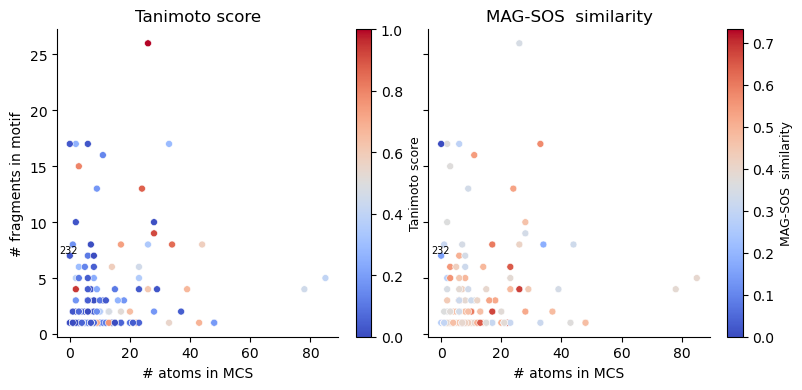

In [18]:
plot_facet_grid(results_sos)

In [19]:
#PLOT with FILTERING
def plot_facet_grid(results):

    df = pd.DataFrame({
        "motif_id": results["motif_ids"],
        "num_atoms": results["num_atoms"],
        "len_frag_loss": results["len_frag_loss"],
        "intra": results["intra_sims"],
        "inter": results["inter_sims"]
    })

    # Clip similarity
    df[["intra", "inter"]] = df[["intra", "inter"]].clip(0, 1)

    df_filtered = df.copy()

    # Left plot: keep only intra > 0.65
    df_filtered.loc[df_filtered["intra"] <= 0.65, "intra"] = None

    # Right plot:
    # Keep inter only if BOTH:
    #   intra > 0.65  AND  inter > 0.65
    mask_right = (df["intra"] > 0.65) & (df["inter"] > 0.65)
    df_filtered.loc[~mask_right, "inter"] = None

    # Melt
    df_long = df_filtered.melt(
        id_vars=["motif_id", "num_atoms", "len_frag_loss"],
        value_vars=["intra", "inter"],
        var_name="type",
        value_name="similarity"
    )

    df_long["similarity"] = df_long["similarity"].clip(0, 1)

    # FacetGrid
    g = sns.FacetGrid(df_long, col="type", height=4, sharex=True, sharey=True)

    # Map scatterplot
    g.map_dataframe(
        sns.scatterplot,
        x="num_atoms",
        y="len_frag_loss",
        hue="similarity",
        palette="coolwarm",
        s=25
    )

    # Rename facet titles
    label_map = {
        "intra": "Tanimoto score",
        "inter": "MAG-SOS  similarity"
    }
    for ax, t in zip(g.axes.flat, g.col_names):
        ax.set_title(label_map[t])

    # Add per-panel colorbars
    for ax, t in zip(g.axes.flat, g.col_names):
        norm = plt.Normalize(df_long.loc[df_long["type"] == t, "similarity"].min(),
                             df_long.loc[df_long["type"] == t, "similarity"].max())
        sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
        sm.set_array([])

        cb = g.fig.colorbar(sm, ax=ax)
        cb.set_label(label_map[t], fontsize=9)

    # Axis labels
    g.set_axis_labels("# atoms in MCS", "# fragments in motif")

    # ---- label motifs, unchanged ----
    #label_df = df[df["motif_id"].isin([24, 970, 232])]

    label_df = df[df["intra"] > 0.90]  # only motifs with intra > 0.65
    for t_name, ax in zip(["intra", "inter"], g.axes.flat):
        texts = []
        for _, row in label_df.iterrows():
            texts.append(
                ax.text(
                    row["num_atoms"],
                    row["len_frag_loss"],
                    str(int(row["motif_id"])),
                    fontsize=7,
                    ha="center", va="center"
                )
            )
        adjust_text(
            texts,
            ax=ax,
            only_move={'points':'y','text':'y'},
            arrowprops=dict(arrowstyle="-", lw=0.3)
        )

    plt.savefig("motif_similarity_plot.jpg", dpi=600)
    plt.show()


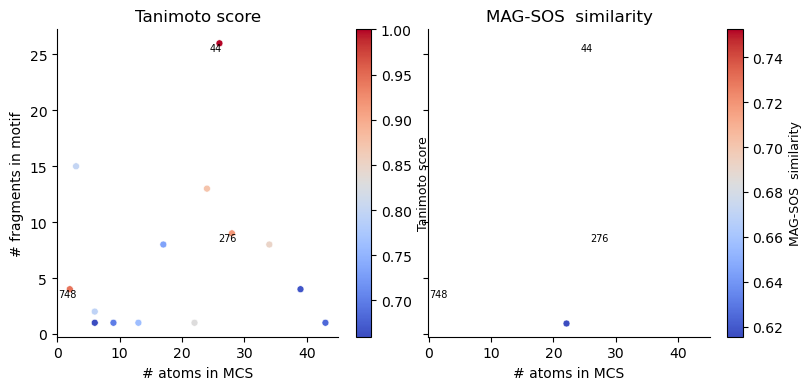

In [20]:
plot_facet_grid(results_sos)

In [6]:
import pickle

with open("/home/ioannis/thesis_data/results_sos.pkl", "rb") as f:
    results_sos = pickle.load(f)


In [7]:
print(results_sos)

{'motif_ids': [416, 518, 238, 450, 359, 431, 262, 343, 488, 621, 259, 638, 583, 432, 351, 548, 280, 172, 620, 96, 601, 66, 737, 632, 204, 652, 12, 740, 716, 388, 326, 265, 586, 478, 519, 123, 722, 94, 691, 212, 531, 232, 555, 341, 53, 165, 739, 663, 707, 394, 299, 93, 605, 197, 11, 696, 457, 582, 349, 456, 230, 159, 340, 301, 65, 715, 28, 458, 48, 374, 296, 121, 350, 381, 29, 731, 502, 256, 558, 729, 595, 705, 449, 444, 276, 446, 309, 645, 270, 111, 408, 689, 421, 175, 734, 579, 129, 606, 590, 714, 499, 63, 467, 500, 75, 59, 166, 246, 451, 171, 541, 74, 372, 748, 101, 550, 163, 434, 161, 686, 675, 10, 698, 223, 252, 559, 433, 546, 600, 180, 599, 733, 365, 743, 521, 630, 76, 23, 209, 393, 15, 284, 592, 219, 266, 472, 482, 721, 678, 392, 383, 83, 108, 295, 424, 43, 294, 535, 190, 56, 114, 653, 680, 581, 113, 279, 703, 659, 306, 192, 557, 476, 331, 278, 35, 336, 195, 704, 210, 118, 438, 335, 347, 3, 619, 274, 289, 624, 47, 512, 534, 436, 208, 425, 701, 664, 57, 461, 618, 143, 321, 746, 41

In [ ]:
df = pd.DataFrame({
    "motif_id": results_sos["motif_ids"],
    "intra": results_sos["intra_sims"],
    "inter": results_sos["inter_sims"],
    "mcs_size": results_sos["num_atoms"],
    "n_features": results_sos["len_frag_loss"],
})

# Filter out obviously bad motifs
df_good = df[
    (df["mcs_size"] > 0) &
    (df["intra"] >= 0.55) &
    (df["inter"] >= 0.55)
].copy()

# Simple combined score (you can adjust weights later)
df_good["quality_score"] = (df_good["intra"] + df_good["inter"] + (df_good["mcs_size"] / df_good["mcs_size"].max()))

df_good = df_good.sort_values("quality_score", ascending=False)

In [9]:
print(len(df_good))

7


In [10]:
df_good

,motif_id,intra,inter,mcs_size,n_features,quality_score
1,518,0.831258,0.683971,22,1,2.361383
19,96,0.615530,0.681212,26,4,2.296742
90,408,0.731790,0.597942,17,8,1.983579
289,61,0.760965,0.646656,13,1,1.907621
310,623,0.550000,0.714623,7,1,1.533853
275,136,0.560606,0.694444,3,1,1.370435
240,100,0.611111,0.577381,2,1,1.265415


In [11]:

from rdkit import Chem
from rdkit.Chem import Draw

def plot_mcs(smarts):
    m = Chem.MolFromSmarts(smarts)
    if m is None:
        print("Could not parse SMARTS")
        return
    display(Draw.MolToImage(m, size=(300, 300)))



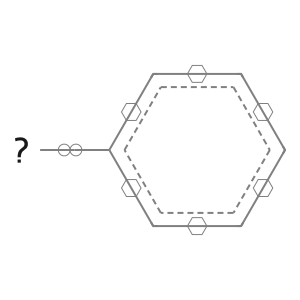

In [28]:
motif_id = 623
idx = results_sos["motif_ids"].index(motif_id)
smarts = results_sos["mcs_smarts"][idx]

plot_mcs(smarts)


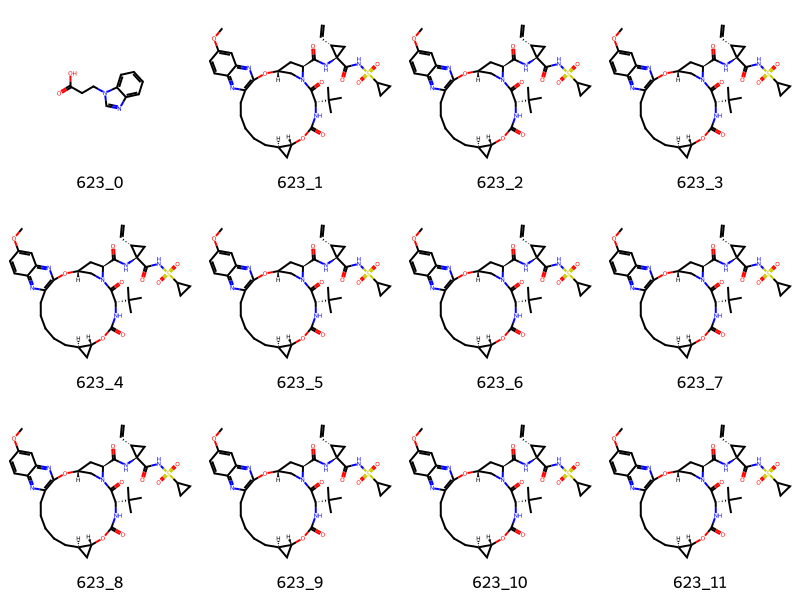

In [29]:
from rdkit.Chem import Draw

def show_motif_molecules(results, motif_id, max_mols=12):
    mols = results["molecules_by_motif"][motif_id][:max_mols]
    legends = [f"{motif_id}_{i}" for i in range(len(mols))]
    img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends)
    display(img)

show_motif_molecules(results_sos, 623)


In [33]:
from rdkit import Chem

mcs_query = Chem.MolFromSmarts(smarts)
highlighted = []
for mol in results_sos["molecules_by_motif"][623]:
    match = mol.GetSubstructMatch(mcs_query)
    highlighted.append(match)


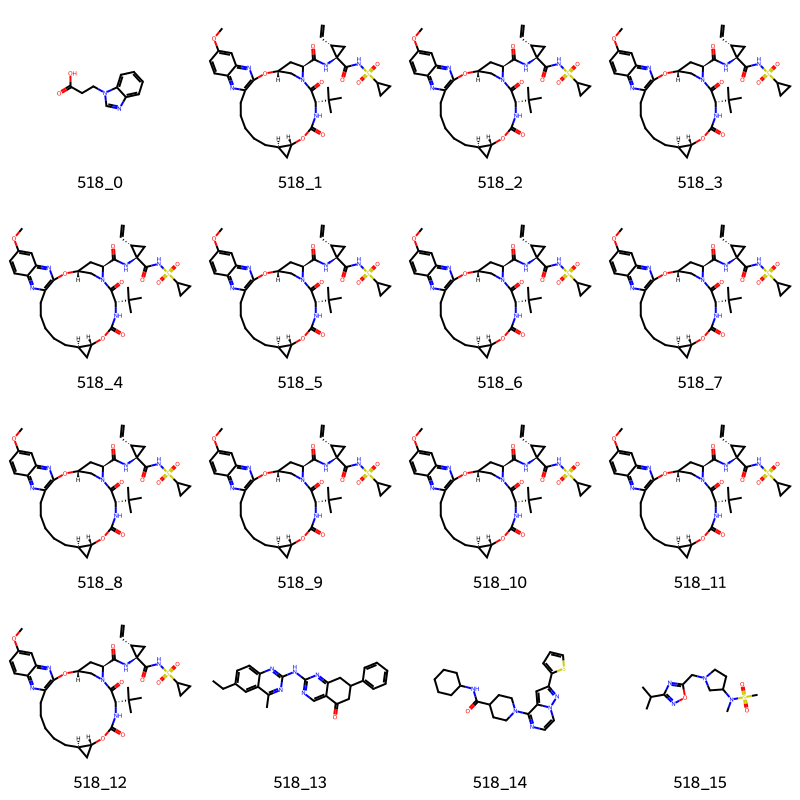

In [34]:
from rdkit.Chem import Draw

mols = results_sos["molecules_by_motif"][623]
legends = [f"518_{i}" for i in range(len(mols))]

img = Draw.MolsToGridImage(
    mols,
    molsPerRow=4,
    subImgSize=(200, 200),
    legends=legends,
    highlightAtomLists=highlighted
)
display(img)


In [19]:
print(smarts)

[#8&!R]=&!@[#6]1:&@[#6](-&!@[#8&!R]):&@[#6](-&!@[#6]2:&@[#6]:&@[#6]:&@[#6](:&@[#6](:&@[#6]:&@2)-&!@[#8&!R])-&!@[#8&!R]):&@[#8]:&@[#6]2:&@[#6]:&@1:&@[#6](:&@[#6]:&@[#6](:&@[#6]:&@2)-&!@[#8&!R])-&!@[#8&!R]
